<a href="https://colab.research.google.com/github/MajdAlkawaas/MajdAlkawaas/blob/main/DL_Lab_Report_MajdAlkawaas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install torch==2.0.0 torchvision==0.15.1
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully

In [ ]:
%matplotlib inline
import random
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from d2l import torch as d2l

## Generating the Dataset

Here we are settung up our `SyntheticRegressionData` class, which provides with  synthetic dataset that is generated with this particular function $$ y = -\sin(10\pi (x+0.5)\sin(x^3))+\epsilon, $$

We also, provide the utiltiy functions (generator) needed for preparing the data for traning, which loads the traning and validation data in batches.

In [ ]:
# Questions:
# How do the w and b fit with generated data
# The w, b params cannot have values here.

class SyntheticRegressionData(d2l.DataModule):
  """Synthetic data for linear regression."""
  def __init__(self, noise=0.1, num_train=500, num_val=500, batch_size=100):
    super().__init__()
    self.save_hyperparameters()
    n = num_train + num_val
    self.X = torch.rand(n,1) -0.5
    epsilon    = torch.randn(n,1)*noise + 0
    self.y     = self.ground_truth_function(self.X) + epsilon


  def ground_truth_function(self,x):
    return -torch.sin((10*math.pi*(x+0.5)*torch.sin((x)**3)))


  def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)



@d2l.add_to_class(d2l.DataModule)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

In [ ]:
data = SyntheticRegressionData()

In [ ]:
print(data.X.shape)
print(data.y.shape)

torch.Size([1000, 1])
torch.Size([1000, 1])


In [ ]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([0.2163]) 
label: tensor([-0.1027])


## Reading the Dataset

Here we are showing how the `dataloader()` works. As we see it is a generator that provides us with our data in batches, and has the appropaite length which is calculated in the following way.

$$  \left\lceil{\frac{train Size + val Size}{batch Size}} \right\rceil $$


In [ ]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

print(f"Data Loader Length: {len(data.train_dataloader())}")

X shape: torch.Size([100, 1]) 
y shape: torch.Size([100, 1])
Data Loader Length: 5


## The Model

Here we are setting up our regression model.

Our model consist of an input layer, a hidden layer with a ReLU activation and a linear output layer with no activation, because we are doing regression.

For loss we are using the `MSELoss` given that we are dealing with a regression problem.

As we can see in the model class that we use in d2l we setup the model, define the loss, and the optimizer. Which is slightly different than waht PyTorch does.

Moreover, the class implementation in d2l provides the training loop with a plotting function, which the training loop uses plot the learning curve.

In [ ]:
class NonLinearRegression(d2l.Module):
  """The linear regression model implemented with high-level APIs."""
  def __init__(self, lr):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(1, 10), nn.ReLU(), nn.Linear(10, 1))
    self.lr = lr


  def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

  def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr, momentum=0.9)


  def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)

## Training

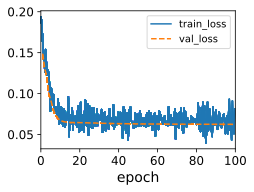

In [ ]:
model = NonLinearRegression(lr=0.01)
data = SyntheticRegressionData()
trainer = d2l.Trainer(max_epochs=100)
trainer.fit(model, data)


Text(0, 0.5, '$y$')

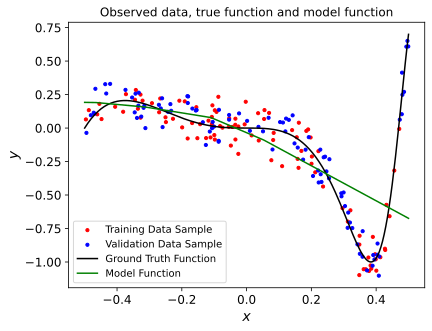

In [ ]:

# ********** DO NOT MODIFY THIS CODE ********** #

# ********** IT SHOULD WORK WITHOUT CHANGING THIS CODE ********** #

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

X = data.X.squeeze(1)
y = data.y.squeeze(1)

xgrid = torch.linspace(torch.min(X),torch.max(X),10)

fig = plt.figure()
plt.scatter(X[0:100],y[0:100],10,'r')
plt.scatter(X[100:200],y[100:200],10,'b')

plt.plot(xgrid,data.ground_truth_function(xgrid),'k')
plt.plot(data.X,model(data.X).detach().numpy(),'g')

plt.title('Observed data, true function and model function')
plt.legend(['Training Data Sample','Validation Data Sample', 'Ground Truth Function','Model Function'])
plt.xlabel('$x$')
plt.ylabel('$y$')


## Refelction:

- The model does not fit the data with have generated even though the validation loss is relatively low.

- My interuptation is that the model is stuck at a particular local minimum, that is good enough to get a relatively small traning and validation loss but not bad enough to keep pushing the gradients from this particular minimum. This is evident from the vibrating traning loss.